# Online Retail Customer Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
sns.set_style("whitegrid")
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

In [3]:
df = pd.read_excel("../data/online_retail.xlsx", sheet_name=0)

In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [6]:
df.describe(include=[np.number]).style.format("{:.2f}")

,Quantity,Price,Customer ID
count,525461.00,525461.00,417534.00
mean,10.34,4.69,15360.65
std,107.42,146.13,1680.81
min,-9600.00,-53594.36,12346.00
25%,1.00,1.25,13983.00
50%,3.00,2.10,15311.00
75%,10.00,4.21,16799.00
max,19152.00,25111.09,18287.00


In [7]:
df.describe(include=[object])

,Invoice,StockCode,Description,Country
count,525461,525461,522533,525461
unique,28816,4632,4681,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,675,3516,3549,485852


### Invoice

In [8]:
df["Invoice"] = df["Invoice"].astype("str")

df[df["Invoice"].str.match(r"^\d{6}$") == False]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom


In [9]:
df["Invoice"].str.replace("[0-9]", "", regex=True).unique()

array(['', 'C', 'A'], dtype=object)

In [10]:
df[df["Invoice"].str.startswith("A")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


In [11]:
df[df["Invoice"].str.startswith("C")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom


In [12]:
df["Invoice"].apply(
    lambda x: "6-digit Original" if len(x) == 6 else ("Cancellation" if x.startswith("C") else "Adjustment")
).value_counts()

Invoice
6-digit Original    515252
Cancellation         10206
Adjustment               3
Name: count, dtype: int64

### StockCode

In [13]:
df["StockCode"] = df["StockCode"].astype("str")

df[df["StockCode"].str.match(r"^\d{5}$") == False]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
12,489436,48173C,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.95,13078.0,United Kingdom
23,489436,35004B,SET OF 3 BLACK FLYING DUCKS,12,2009-12-01 09:06:00,4.65,13078.0,United Kingdom
28,489436,84596F,SMALL MARSHMALLOWS PINK BOWL,8,2009-12-01 09:06:00,1.25,13078.0,United Kingdom
...,...,...,...,...,...,...,...,...
525387,538170,84029E,RED WOOLLY HOTTIE WHITE HEART.,2,2010-12-09 19:32:00,3.75,13969.0,United Kingdom
525388,538170,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2,2010-12-09 19:32:00,3.75,13969.0,United Kingdom
525389,538170,85232B,SET OF 3 BABUSHKA STACKING TINS,2,2010-12-09 19:32:00,4.95,13969.0,United Kingdom
525435,538171,47591D,PINK FAIRY CAKE CHILDRENS APRON,1,2010-12-09 20:01:00,1.95,17530.0,United Kingdom


In [14]:
filter1 = df["StockCode"].str.match(r"^\d{5}$") == False
filter2 = df["StockCode"].str.match(r"^\d{5}[a-zA-Z]+$") == False

stock_codes = df[filter1 & filter2]
stock_code_counts = stock_codes["StockCode"].value_counts()

print(f"Codes Count: {stock_code_counts.shape[0]}")
stock_code_counts

Codes Count: 55


StockCode
POST            865
M               850
DOT             736
C2              138
D               100
ADJUST           67
BANK CHARGES     65
S                41
DCGS0058         31
gift_0001_30     21
gift_0001_20     19
TEST001          15
PADS             15
DCGS0076         13
DCGSSBOY         12
DCGSSGIRL        12
AMAZONFEE         9
DCGS0003          9
gift_0001_10      7
gift_0001_40      4
DCGS0004          4
DCGS0069          4
m                 4
gift_0001_80      4
DCGS0066N         4
gift_0001_50      4
ADJUST2           3
DCGS0072          3
B                 3
SP1002            3
gift_0001_70      3
DCGS0068          2
DCGS0037          2
DCGS0062          2
TEST002           2
gift_0001_60      2
gift_0001_90      2
DCGS0056          1
GIFT              1
DCGS0044          1
C3                1
47503J            1
DCGS0041          1
DCGS0075          1
DCGS0070          1
DCGS0006          1
DCGS0016          1
DCGSLGIRL         1
DCGS0027          1
DCGS0036  

In [15]:
df[df["StockCode"].str.contains(r"^PADS", regex=True, na=False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
62299,494914,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-01-19 17:04:00,0.001,16705.0,United Kingdom
74731,496222,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-01-29 13:53:00,0.001,13583.0,United Kingdom
77702,496473,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-01 15:38:00,0.001,17350.0,United Kingdom
79794,496643,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-03 11:58:00,0.001,13408.0,United Kingdom
90798,497935,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-15 10:47:00,0.001,13408.0,United Kingdom
97716,498562,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-21 12:03:00,0.001,15182.0,United Kingdom
101718,499056,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-24 13:46:00,0.001,13765.0,United Kingdom
104480,499399,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-26 13:26:00,0.001,14459.0,United Kingdom
123947,501176,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-03-15 11:00:00,0.001,14857.0,United Kingdom
156809,504332,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-04-12 16:30:00,0.001,12671.0,Germany


### Quantity

In [16]:
negative_quantity = df[df["Quantity"] < 0]
negative_quantity.shape

(12326, 8)

In [17]:
negative_quantity.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
183,C489449,21871,SAVE THE PLANET MUG,-12,2009-12-01 10:33:00,1.25,16321.0,Australia
184,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,-12,2009-12-01 10:33:00,1.25,16321.0,Australia
185,C489449,84970S,HANGING HEART ZINC T-LIGHT HOLDER,-24,2009-12-01 10:33:00,0.85,16321.0,Australia
186,C489449,22090,PAPER BUNTING RETRO SPOTS,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
196,C489459,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592.0,United Kingdom


### Price 

In [18]:
null_count = df["Price"].isnull().sum()
print(f"Price Null Count: {null_count}")

Price Null Count: 0


In [19]:
df[["Price"]].describe().style.format("{:.2f}")

,Price
count,525461.00
mean,4.69
std,146.13
min,-53594.36
25%,1.25
50%,2.10
75%,4.21
max,25111.09


In [20]:
df.corr(numeric_only=True)["Price"]

Quantity      -0.001931
Price          1.000000
Customer ID   -0.003266
Name: Price, dtype: float64

### Customer ID

In [21]:
null_ids = df[df["Customer ID"].isna()]
null_ids.shape

(107927, 8)

In [22]:
null_ids.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1058,489548,22195,LARGE HEART MEASURING SPOONS,1,2009-12-01 12:32:00,1.65,NaN,United Kingdom


### Country

In [23]:
country_counts = df["Country"].value_counts()

print(f"Total Countries Count: {country_counts.shape[0]}")
country_counts

Total Countries Count: 40


Country
United Kingdom          485852
EIRE                      9670
Germany                   8129
France                    5772
Netherlands               2769
Spain                     1278
Switzerland               1187
Portugal                  1101
Belgium                   1054
Channel Islands            906
Sweden                     902
Italy                      731
Australia                  654
Cyprus                     554
Austria                    537
Greece                     517
United Arab Emirates       432
Denmark                    428
Norway                     369
Finland                    354
Unspecified                310
USA                        244
Japan                      224
Poland                     194
Malta                      172
Lithuania                  154
Singapore                  117
RSA                        111
Bahrain                    107
Canada                      77
Hong Kong                   76
Thailand                    76


## Data Cleaning

In [24]:
cleaned_df = df.copy()

In [25]:
cleaned_df["Invoice"] = cleaned_df["Invoice"].astype("str")
mask = cleaned_df["Invoice"].str.match(r"^\d{6}$") == True

cleaned_df = cleaned_df[mask]

In [26]:
cleaned_df["StockCode"] = cleaned_df["StockCode"].astype("str")

mask = (
    (cleaned_df["StockCode"].str.match(r"^\d{5}$") == True) | 
    (cleaned_df["StockCode"].str.match(r"^\d{5}[a-zA-Z]+$") == True) | 
    (cleaned_df["StockCode"].str.match("^PADS$") == True)
)

cleaned_df = cleaned_df[mask]

In [27]:
cleaned_df.dropna(subset=["Customer ID"], inplace=True)

In [28]:
cleaned_df.sample(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
252201,513674,21610,SET 12 PEAR BOTANICAL T-LIGHTS,6,2010-06-28 11:39:00,2.95,16012.0,United Kingdom
436889,531135,21644,ASSORTED TUTTI FRUTTI HEART BOX,8,2010-11-05 14:09:00,1.25,16919.0,United Kingdom
48555,493954,84029E,RED WOOLLY HOTTIE WHITE HEART.,24,2010-01-08 14:10:00,2.95,18170.0,United Kingdom
129779,501718,79144C,PAINTED LIGHTBULB RAINBOW DESIGN,6,2010-03-19 10:40:00,0.42,15325.0,United Kingdom
210458,509743,22505,MEMO BOARD COTTAGE DESIGN,1,2010-05-25 13:21:00,4.95,17841.0,United Kingdom
147801,503436,21124,SET/10 BLUE SPOTTY PARTY CANDLES,24,2010-04-01 09:50:00,1.25,12662.0,Germany
224092,511073,21205,MULTICOLOUR 3D BALLS GARLAND,1,2010-06-06 13:42:00,2.55,13614.0,United Kingdom
200286,508628,22624,IVORY KITCHEN SCALES,1,2010-05-17 14:17:00,8.50,15280.0,United Kingdom
112613,500151,22294,HEART FILIGREE DOVE SMALL,2,2010-03-04 17:45:00,1.25,17931.0,United Kingdom
105397,499481,84828,JUNGLE POPSICLES ICE LOLLY HOLDERS,24,2010-02-28 13:07:00,1.25,16843.0,United Kingdom


In [29]:
cleaned_df.describe(include=[np.number]).style.format("{:.2f}")

,Quantity,Price,Customer ID
count,406337.00,406337.00,406337.00
mean,13.62,2.99,15373.63
std,97.00,4.29,1677.37
min,1.00,0.00,12346.00
25%,2.00,1.25,14004.00
50%,5.00,1.95,15326.00
75%,12.00,3.75,16814.00
max,19152.00,295.00,18287.00


In [30]:
print(f"Negative Price Count (Before): {len(cleaned_df[cleaned_df["Price"] <= 0.0])}")
cleaned_df = cleaned_df[cleaned_df["Price"] > 0.0]
print(f"Negative Price Count (After): {len(cleaned_df[cleaned_df["Price"] <= 0.0])}")

Negative Price Count (Before): 28
Negative Price Count (After): 0


In [31]:
cleaned_df.describe(include=[np.number]).style.format("{:.2f}")

,Quantity,Price,Customer ID
count,406309.00,406309.00,406309.00
mean,13.62,2.99,15373.72
std,97.00,4.29,1677.33
min,1.00,0.00,12346.00
25%,2.00,1.25,14006.00
50%,5.00,1.95,15326.00
75%,12.00,3.75,16814.00
max,19152.00,295.00,18287.00


In [32]:
print(f"Current Minimum Price: {cleaned_df["Price"].min()}")

Current Minimum Price: 0.001


In [33]:
print(f"Total Data Dropped: {round(1 - len(cleaned_df)/len(df), 3)*100}%")

Total Data Dropped: 22.7%


## Feature Engineering

In [34]:
cleaned_df["SalesLineTotal"] = cleaned_df["Quantity"] * cleaned_df["Price"]

In [35]:
cleaned_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,SalesLineTotal
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [36]:
aggregated_df = cleaned_df.groupby(by="Customer ID", as_index=False).agg(
    MonetaryValue=("SalesLineTotal", "sum"),
    Frequency=("Invoice", "nunique"),
    LastInvoiceDate=("InvoiceDate", "max")
)

In [37]:
aggregated_df.head()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate
0,12346.0,169.36,2,2010-06-28 13:53:00
1,12347.0,1323.32,2,2010-12-07 14:57:00
2,12348.0,221.16,1,2010-09-27 14:59:00
3,12349.0,2221.14,2,2010-10-28 08:23:00
4,12351.0,300.93,1,2010-11-29 15:23:00


In [38]:
max_invoice_date = aggregated_df["LastInvoiceDate"].max()
aggregated_df["Recency"] = (max_invoice_date - aggregated_df["LastInvoiceDate"]).dt.days

In [39]:
aggregated_df.head()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
0,12346.0,169.36,2,2010-06-28 13:53:00,164
1,12347.0,1323.32,2,2010-12-07 14:57:00,2
2,12348.0,221.16,1,2010-09-27 14:59:00,73
3,12349.0,2221.14,2,2010-10-28 08:23:00,42
4,12351.0,300.93,1,2010-11-29 15:23:00,10


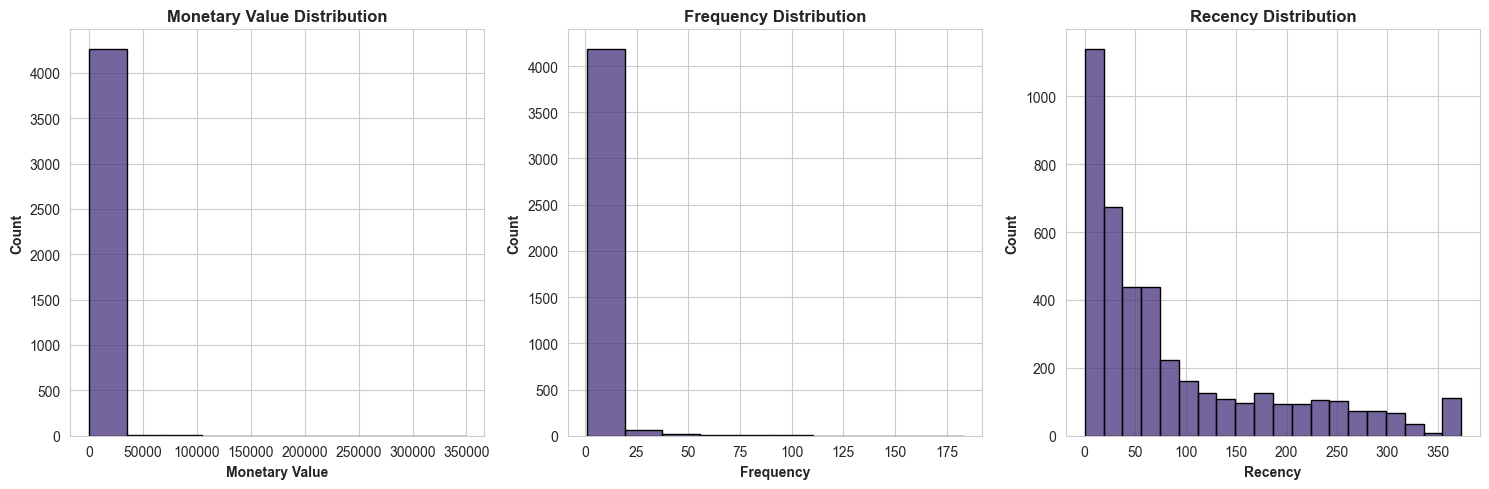

In [40]:
plt.subplot(1, 3, 1)
sns.histplot(aggregated_df['MonetaryValue'], bins=10, edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.histplot(aggregated_df['Frequency'], bins=10, edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.histplot(aggregated_df['Recency'], bins=20, edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

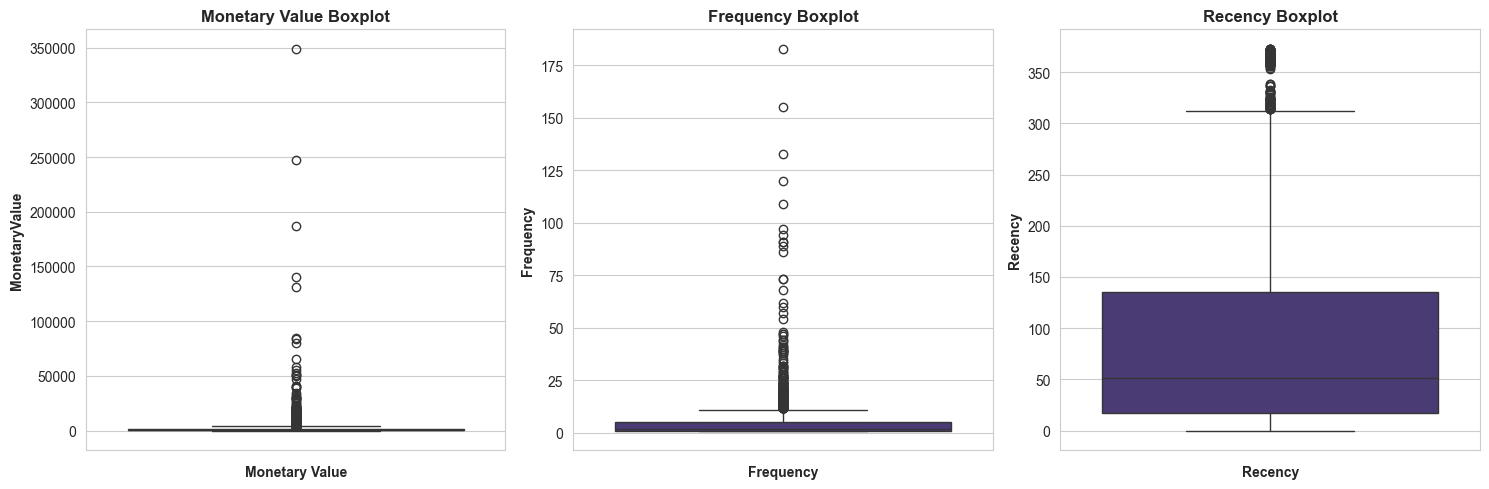

In [41]:
plt.subplot(1, 3, 1)
sns.boxplot(data=aggregated_df['MonetaryValue'])
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=aggregated_df['Frequency'])
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=aggregated_df['Recency'])
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

In [42]:
M_Q1 = aggregated_df["MonetaryValue"].quantile(0.25)
M_Q3 = aggregated_df["MonetaryValue"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

monetary_outliers_df = aggregated_df[
    (aggregated_df["MonetaryValue"] > (M_Q3 + 1.5 * M_IQR)) | 
    (aggregated_df["MonetaryValue"] < (M_Q1 - 1.5 * M_IQR))
].copy()

In [43]:
monetary_outliers_df.describe(include=[np.number]).style.format("{:.2f}")

,Customer ID,MonetaryValue,Frequency,Recency
count,423.00,423.00,423.00,423.00
mean,15103.04,12188.10,17.17,30.04
std,1728.66,25830.85,19.73,51.54
min,12357.00,3802.04,1.00,0.00
25%,13622.00,4605.94,8.00,3.00
50%,14961.00,6191.32,12.00,13.00
75%,16692.00,10273.24,18.00,31.00
max,18260.00,349164.35,183.00,364.00


In [44]:
F_Q1 = aggregated_df['Frequency'].quantile(0.25)
F_Q3 = aggregated_df['Frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1

frequency_outliers_df = aggregated_df[
    (aggregated_df['Frequency'] > (F_Q3 + 1.5 * F_IQR)) | 
    (aggregated_df['Frequency'] < (F_Q1 - 1.5 * F_IQR))
].copy()

In [45]:
frequency_outliers_df.describe(include=[np.number]).style.format("{:.2f}")

,Customer ID,MonetaryValue,Frequency,Recency
count,279.00,279.00,279.00,279.00
mean,15352.66,14409.71,23.81,16.09
std,1748.43,31381.74,21.93,26.59
min,12437.00,1094.39,12.00,0.00
25%,13800.00,4331.56,13.00,2.00
50%,15465.00,6615.77,17.00,7.00
75%,16828.50,11692.41,23.00,19.00
max,18260.00,349164.35,183.00,211.00


In [46]:
non_outliers_df = aggregated_df[
    (~aggregated_df.index.isin(monetary_outliers_df.index)) & 
    (~aggregated_df.index.isin(frequency_outliers_df.index))
]

In [47]:
non_outliers_df.describe(include=[np.number]).style.format("{:.2f}")

,Customer ID,MonetaryValue,Frequency,Recency
count,3809.00,3809.00,3809.00,3809.00
mean,15376.48,885.50,2.86,97.08
std,1693.20,817.67,2.24,98.11
min,12346.00,1.55,1.00,0.00
25%,13912.00,279.91,1.00,22.00
50%,15389.00,588.05,2.00,58.00
75%,16854.00,1269.05,4.00,154.00
max,18287.00,3788.21,11.00,373.00


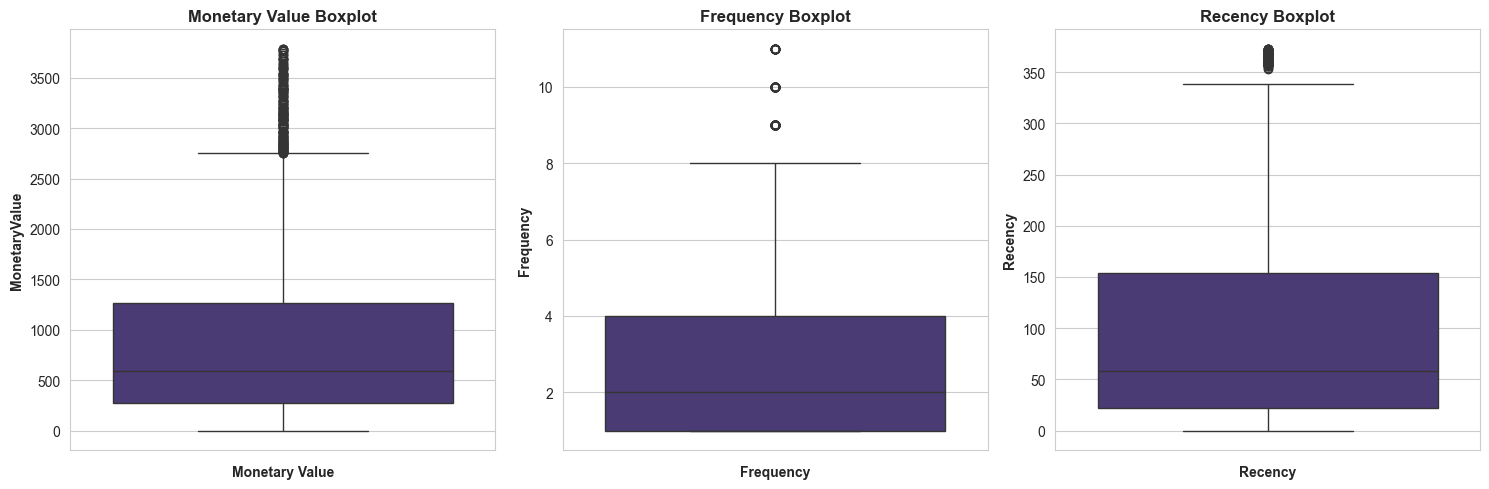

In [48]:
plt.subplot(1, 3, 1)
sns.boxplot(data=non_outliers_df['MonetaryValue'])
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=non_outliers_df['Frequency'])
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=non_outliers_df['Recency'])
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

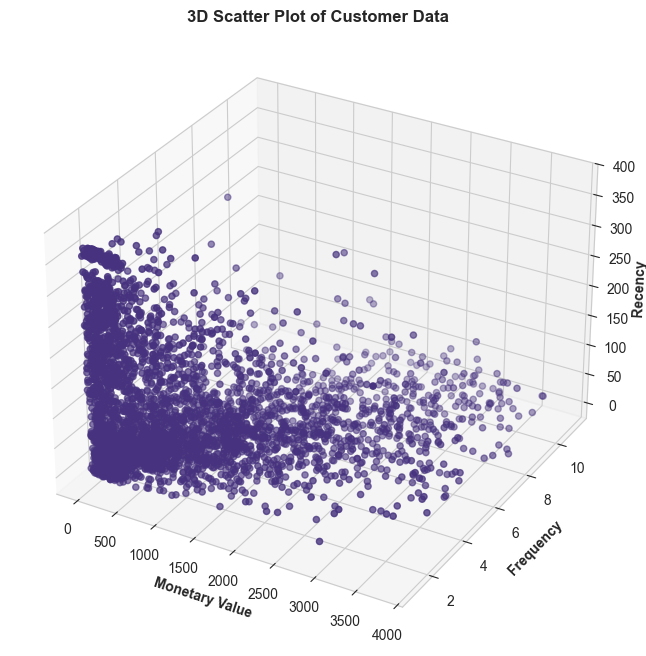

In [49]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outliers_df["MonetaryValue"], non_outliers_df["Frequency"], non_outliers_df["Recency"])
ax.set_title('3D Scatter Plot of Customer Data')
ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency', labelpad=0)

plt.show()

In [50]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(non_outliers_df[["MonetaryValue", "Frequency", "Recency"]])

In [51]:
scaled_data

array([[-0.87594534, -0.38488934,  0.68214853],
       [ 0.5355144 , -0.38488934, -0.96925093],
       [-0.81258645, -0.83063076, -0.24548944],
       ...,
       [-0.62197163, -0.83063076,  2.01753946],
       [ 0.44146683, -0.38488934,  0.14187587],
       [ 1.72488781,  0.50659348, -0.81634357]])

In [52]:
scaled_data_df = pd.DataFrame(
    scaled_data, index=non_outliers_df.index, columns=("MonetaryValue", "Frequency", "Recency")
)

In [53]:
scaled_data_df.head()

,MonetaryValue,Frequency,Recency
0,-0.875945,-0.384889,0.682149
1,0.535514,-0.384889,-0.969251
2,-0.812586,-0.830631,-0.245489
3,1.633678,-0.384889,-0.561498
4,-0.715016,-0.830631,-0.887700


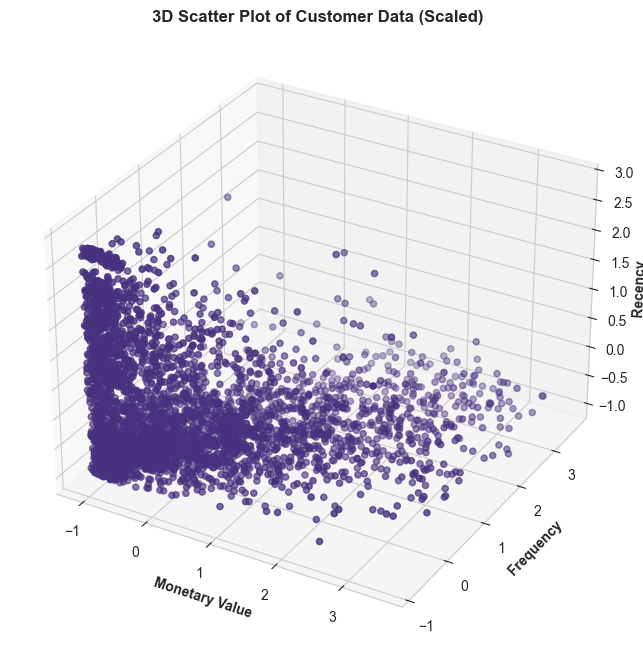

In [54]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_data_df["MonetaryValue"], scaled_data_df["Frequency"], scaled_data_df["Recency"])
ax.set_title('3D Scatter Plot of Customer Data (Scaled)')
ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency', labelpad=0)

plt.show()